# **Factors of Vehicular Collisions that Lead to Injury** 

> By Matthew Fernandez & David Gaeta



## **Introduction**

We will be examining traffic collisions that occured in Montgomery County, Maryland. Our data set has over twelve thousand collision reports based on preliminary data. The data set includes columns such as the time of day that the crash occurred, the vehicle's impact locations, and the vehicle's movement at the time of the collision. We will be using this data to see what aspects of a crash lead to lower or higher rates of injury severity. Therefore, we are most interested in the correlation of 'Injury Severity', 'Vehicle Body Type', and 'Vehicle Movement' and others. We will create new columns based on factors that are most apparent to our exploration of the data.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare, chi2_contingency
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)
drive_loc = "/content/drive/Shared drives/DS Project1/"



Mounted at /content/drive/


The data we are working with comes from [Montgomery County's database](https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Drivers-Data/mmzv-x632) (https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Drivers-Data/mmzv-x632). This data was accessed and downloaded on March , 2021.

In [ ]:
df = pd.read_csv(drive_loc + 'Crash_Reporting_Drivers_Data.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## **Initial Exploration**

The dataset has 121400 samples with 43 columns.

In [ ]:
df.shape

(121400, 43)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121400 entries, 0 to 121399
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Report Number                   121400 non-null  object 
 1   Local Case Number               121400 non-null  object 
 2   Agency Name                     121400 non-null  object 
 3   ACRS Report Type                121400 non-null  object 
 4   Crash Date/Time                 121400 non-null  object 
 5   Route Type                      109654 non-null  object 
 6   Road Name                       110252 non-null  object 
 7   Cross-Street Type               109640 non-null  object 
 8   Cross-Street Name               110247 non-null  object 
 9   Off-Road Description            11147 non-null   object 
 10  Municipality                    13301 non-null   object 
 11  Related Non-Motorist            3785 non-null    object 
 12  Collision Type  

Only four of the forty-three column data set are made of numeric values. As seen below, it appears that there may be some faulty data in the 'Vehicle Year' column since the minimum is 0, and the maximum is 9999.

In [ ]:
df.describe()

,Speed Limit,Vehicle Year,Latitude,Longitude
count,121400.000000,121400.000000,121400.000000,121400.000000
mean,32.846623,1968.595461,39.082330,-77.112486
std,11.024062,330.966006,0.072442,0.099789
min,0.000000,0.000000,37.720000,-79.486000
25%,30.000000,2005.000000,39.023317,-77.188268
50%,35.000000,2010.000000,39.074345,-77.105453
75%,40.000000,2014.000000,39.137950,-77.040101
max,70.000000,9999.000000,39.990414,-75.527708


As seen below, there is plenty of missing data that can be taken care of, though some of them such as 'Driver Substance Abuse' could be attributed to the preliminary report leaving the space empty due to there being nothing of note to report, therefore insinuating a "None Detected" classification.

In [ ]:
df.isna().sum()

Report Number                          0
Local Case Number                      0
Agency Name                            0
ACRS Report Type                       0
Crash Date/Time                        0
Route Type                         11746
Road Name                          11148
Cross-Street Type                  11760
Cross-Street Name                  11153
Off-Road Description              110253
Municipality                      108099
Related Non-Motorist              117615
Collision Type                       403
Weather                             9593
Surface Condition                  14300
Light                               1006
Traffic Control                    19123
Driver Substance Abuse             22117
Non-Motorist Substance Abuse      118393
Person ID                              0
Driver At Fault                        0
Injury Severity                        0
Circumstance                       97827
Driver Distracted By                   0
Drivers License 

Below we confirm that all missing data has been accounted for in our largely string based data set.

In [ ]:
(df.select_dtypes(include='object') == "").sum()

Report Number                     0
Local Case Number                 0
Agency Name                       0
ACRS Report Type                  0
Crash Date/Time                   0
Route Type                        0
Road Name                         0
Cross-Street Type                 0
Cross-Street Name                 0
Off-Road Description              0
Municipality                      0
Related Non-Motorist              0
Collision Type                    0
Weather                           0
Surface Condition                 0
Light                             0
Traffic Control                   0
Driver Substance Abuse            0
Non-Motorist Substance Abuse      0
Person ID                         0
Driver At Fault                   0
Injury Severity                   0
Circumstance                      0
Driver Distracted By              0
Drivers License State             0
Vehicle ID                        0
Vehicle Damage Extent             0
Vehicle First Impact Locatio

The plot below provides us some insight into the correlation between the columns we are most interested in.

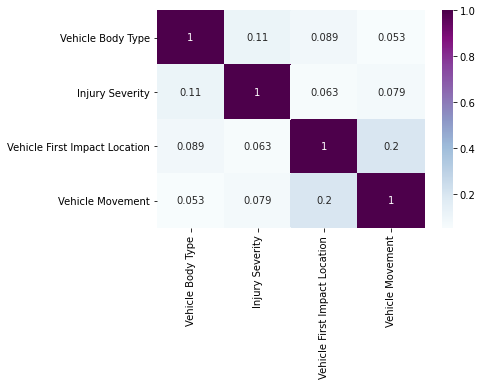

In [ ]:
# source: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def cramers_v(x, y):
  confusion_matrix = pd.crosstab(x,y)
  chi2 = chi2_contingency(confusion_matrix)[0]
  n = confusion_matrix.sum().sum()
  phi2 = chi2/n
  r,k = confusion_matrix.shape
  phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
  rcorr = r-((r-1)**2)/(n-1)
  kcorr = k-((k-1)**2)/(n-1)
  return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))



xs = np.array([ 'Vehicle Body Type', 'Injury Severity', 'Vehicle First Impact Location', 'Vehicle Movement'])
n = len(xs)
cor_mtx = np.zeros([n, n])
for i in range(n):
  for j in range(n):
    cor_mtx[i,j] = cramers_v(df[xs[i]], df[xs[j]])

sns.heatmap(cor_mtx, xticklabels=xs, yticklabels=xs, annot=True, cmap="BuPu")

## **Data Cleaning and Preprocessing**

Before cleaning anything, we want to index our dataset by the time and date that the collision occurred. This will let us have a more meaningful index as opposed to an arbitrary set of characters. In addition, we'll add columns for the hour, month, and year in order to have easy access to the information if need be.


In [ ]:
df.index = pd.to_datetime(df['Crash Date/Time'])
df = df.sort_index()
df['Hour'] = df.index.hour
df['Month'] = df.index.month
df['Year'] = df.index.year

We initially cleaned the data based off of columns that were missing over 10% of its values. We then removed columns that gave us no analyzable data such as identification numbers and road names, in addition to location data since we didn't feel like it would be useful in what we were looking for.

In [ ]:
df.drop(columns=df.columns[df.isna().mean() >= .10], inplace=True)

df.drop(['Crash Date/Time', 'Local Case Number', 'Person ID','Vehicle ID', 'Route Type', 'Road Name', 'Cross-Street Type', 'Cross-Street Name','Latitude', 'Longitude', 'Location'],axis=1, inplace=True)

In order to more easily look and analyze some of the columns we are interested in, we'll be consolidating some of the values together.  In addition, we'll be giving numeric values to 'Injury Severity', where "No Apparent Injury" is a 0 and "Fatal Injury" is a 4.

In [ ]:
# group other and unkown together
df['First Impact Simple'] = df['Vehicle First Impact Location'].replace({'ELEVEN OCLOCK': "Front", 'TWELVE OCLOCK': "Front", 'ONE OCLOCK': "Front", 'TWO OCLOCK': "Right", 'THREE OCLOCK': "Right", 'FOUR OCLOCK': "Right", 'FIVE OCLOCK': "Back", 'SIX OCLOCK': "Back", 'SEVEN OCLOCK': "Back", 'EIGHT OCLOCK': "Left", 'NINE OCLOCK': "Left", 'TEN OCLOCK': "Left", 'ROOF TOP': "Top", 'UNDERSIDE': "Bottom", 'NON-COLLISION': "No Collision",'UNKNOWK': "Unknown"})
# We will drop these values because they are unusual to compare with collisions 
df.drop(df.index[df['First Impact Simple'] == 'UNKNOWN'], inplace=True)
df.drop(df.index[df['First Impact Simple'] == 'Top'], inplace=True)
df.drop(df.index[df['First Impact Simple'] == 'Bottom'], inplace=True)
df.drop(df.index[df['First Impact Simple'] == 'No Collision'], inplace = True)

df.drop(df.index[df['Vehicle Movement'] == "DRIVERLESS MOVING VEH."], inplace=True)
df['Vehicle Movement'].replace({'RIGHT TURN ON RED': "MAKING A TURN", 'MAKING RIGHT TURN': "MAKING A TURN", 'MAKING LEFT TURN': "MAKING A TURN", 'MAKING U TURN': "MAKING A TURN", 'OTHER': "UNKNOWN", 'ENTERING TRAFFIC LANE': "ENTERING/LEAVING TRAFFIC LANE", 'LEAVING TRAFFIC LANE': "ENTERING/LEAVING TRAFFIC LANE" }, inplace=True)

df['Numeric Severity'] = df['Injury Severity'].replace({'NO APPARENT INJURY': 0, 'POSSIBLE INJURY': 1, 'SUSPECTED MINOR INJURY': 2, 'SUSPECTED SERIOUS INJURY':3, 'FATAL INJURY':4})

We will also be removing "Other", "Unknown", and "Farm Vehicle" from the 'Vehicle Body Type' column to remove unwanted values. In addition, we'll make a new column ‘Cars & Motorcycles’ where we just want these two vehicle subcategories to plot further in our report.

In [ ]:
# WANT TO REMOVE THESE VALS FROM COLUMN TOO AMBIGUOUS TO KEEP
df.drop(df.index[df['Vehicle Body Type'] == 'OTHER'], inplace = True)
df.drop(df.index[df['Vehicle Body Type'] == 'UNKNOWN'], inplace = True)
df.drop(df.index[df['Vehicle Body Type'] == 'FARM VEHICLE'], inplace = True)

df['Size of Vehicle'] = df['Vehicle Body Type'].replace({'POLICE VEHICLE/EMERGENCY': 'EMERGENCY', 'AMBULANCE/EMERGENCY': 'EMERGENCY', 'FIRE VEHICLE/EMERGENCY': 'EMERGENCY', 'POLICE VEHICLE/NON EMERGENCY': 'NON EMERGENCY', 'FIRE VEHICLE/NON EMERGENCY': 'NON EMERGENCY', 'AMBULANCE/NON EMERGENCY': 'NON EMERGENCY', 'STATION WAGON':'PASSENGER CAR', 'TRANSIT BUS':'BUS', 'SCHOOL BUS':'BUS', 'OTHER BUS':'BUS', 'CROSS COUNTRY BUS':'BUS', '(SPORT) UTILITY VEHICLE':'PASSENGER CAR', 'MOPED':'MOTORCYCLE', 'SNOWMOBILE':'RECREATIONAL VEHICLE', 'AUTOCYCLE':'RECREATIONAL VEHICLE', 'LOW SPEED VEHICLE':'RECREATIONAL VEHICLE', 'ALL TERRAIN VEHICLE (ATV)':'RECREATIONAL VEHICLE', 'LIMOUSINE':'PASSENGER CAR', 'OTHER LIGHT TRUCKS (10,000LBS (4,536KG) OR LESS)':'PICKUP TRUCK', 'CARGO VAN/LIGHT TRUCK 2 AXLES (OVER 10,000LBS (4,536 KG))':'CARGO VAN', 'MEDIUM/HEAVY TRUCKS 3 AXLES (OVER 10,000LBS (4,536KG))':'TRUCK TRACTOR'})
# We just want Cars and Motorcycles so lets remove values we dont want to see a correlation b/w
df['Cars & Motorcycles'] = df['Size of Vehicle']
df.drop(df.index[df['Cars & Motorcycles'] == 'BUS'], inplace = True)
df.drop(df.index[df['Cars & Motorcycles'] == 'CARGO VAN'], inplace = True)
df.drop(df.index[df['Cars & Motorcycles'] == 'EMERGENCY'], inplace = True)
df.drop(df.index[df['Cars & Motorcycles'] == 'VAN'], inplace = True)
df.drop(df.index[df['Cars & Motorcycles'] == 'NON EMERGENCY'], inplace = True)
df.drop(df.index[df['Cars & Motorcycles'] == 'RECREATIONAL VEHICLE'], inplace = True)
df.drop(df.index[df['Cars & Motorcycles'] == 'TRUCK TRACTOR'], inplace = True)
df.drop(df.index[df['Cars & Motorcycles'] == 'PICKUP TRUCK'], inplace = True)


## **Data Exploration and Visualization**

What are the frequencies of incidents in the 'Injury Severity' column?




(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

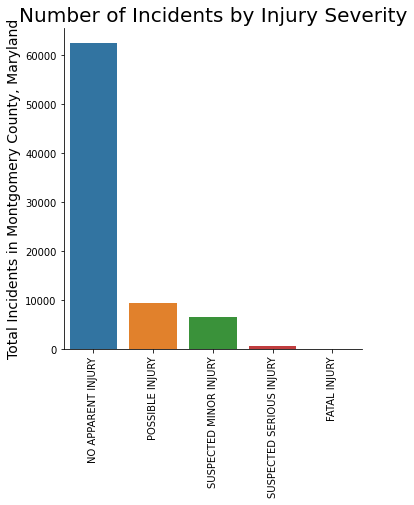

In [ ]:
sns.catplot(x='Injury Severity', kind = 'count', data=df, order = ['NO APPARENT INJURY','POSSIBLE INJURY','SUSPECTED MINOR INJURY','SUSPECTED SERIOUS INJURY','FATAL INJURY'])
plt.title('Number of Incidents by Injury Severity', size=20)
plt.ylabel('Total Incidents in Montgomery County, Maryland', size = 14)
plt.xlabel('')
plt.xticks(rotation=90);

The majority of incidents in the data set are labeled as "No Apparent Injury", however, we are most intrested in incidents involving an injury. The data shows that the more sever of an injury from an incident dramatically declines(note that there are 63 fatal injuries). Individuals involved in incidents, are typcially going to walk away with no apparent injury.

Are there any vehicle movements that may lead to a higher risk of injury?

([<matplotlib.axis.YTick at 0x7f08fcf09610>,
 <a list of 13 Text major ticklabel objects>)

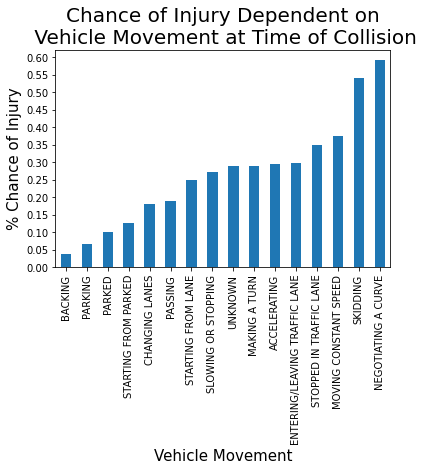

In [ ]:
df.groupby('Vehicle Movement')['Numeric Severity'].mean().sort_values().plot.bar()
plt.title('Chance of Injury Dependent on\n Vehicle Movement at Time of Collision', size=20)
plt.ylabel('% Chance of Injury', size = 15)
plt.xlabel("Vehicle Movement", size = 15)
plt.yticks(ticks=np.arange(0.0, .61, .05));

Take note that the three lowest values involve the vehicle being either stationary, or moving very slowly. These situations lead to less instances in which the vehicle would be hit by fast moving vehicles, leading to the smaller injury chance. This is in contrast to the two movements with the highest chance of injury involving situations in which the vehicle is unable to control their speed and momentum. This more aggressive and reckless driving explains the sharp increase in injury chance. 

Looking at cars and motorcycles, what is the probability of injury severity?

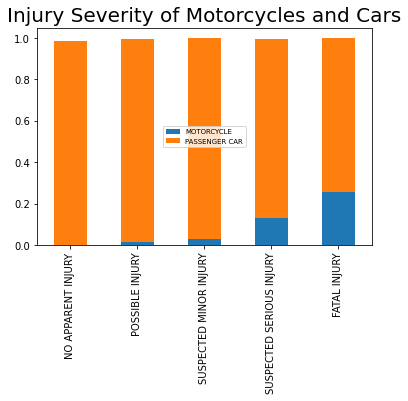

In [ ]:
tbl = pd.crosstab(df['Injury Severity'], df['Cars & Motorcycles'])
tbl = tbl.div(df['Injury Severity'].value_counts(), axis = 0)
tbl.iloc[[1,2,3,4,0]].plot.bar(stacked=True);
plt.title('Injury Severity of Motorcycles and Cars', size=20)
plt.legend(loc = 'center', prop={"size": 7});


Notice that as the injury severity increases, motorcycle accidents have a positive trend for the worse. There is a much higher probability that a motorcyclist involved in an accident, is categorized as a "Fatal Injury", as opposed to "No Apparent Injury". Being on a motorcycle does indeed put a much higher probability of being in a injury. This is due to a lack of structural support, motorcylces are not designed to withstand an impact. The probability of a person, in a passenger car, getting an injury declines as the injury severity increases. 

Are there any impact locations that are prefered in regards to injury severity? And are there any that are more likely to lead to serious injuries?

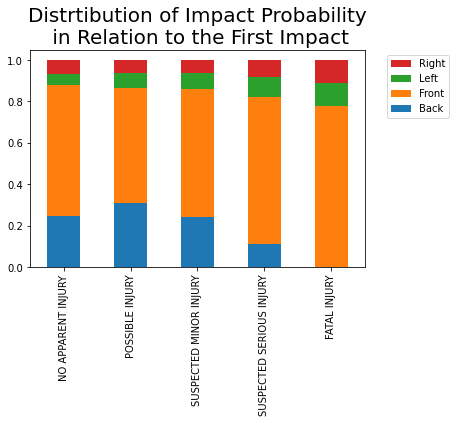

In [ ]:
movementImpact = pd.crosstab(df['Injury Severity'], df['First Impact Simple'])
movementImpact = movementImpact.div(df['Injury Severity'].value_counts(), axis=0)
movementImpact.iloc[[1,2,3,4,0]].plot.bar(stacked=True)
plt.title('Distrtibution of Impact Probability\n in Relation to the First Impact', size=20)
plt.xlabel("")
plt.xticks(rotation = 90)

current_handles, curr_labels = plt.gca().get_legend_handles_labels()
reversed_handles = reversed(current_handles)
reverse_labels = reversed(curr_labels)

plt.legend(reversed_handles, reverse_labels, bbox_to_anchor=(1.05, 1.0), loc='upper left');

We can see that there are no fatal accidents that occured in which the first impact was from behind. This can insinuate that although you may get injured, it may be the safest location to be hit from. This makes sense when you consider that there is a lot of collapsable space between the collision point and the driver. In addition, the vehicle is probably moving in the same direction as the point of collision, leading to a lower impact force on the driver. This is in contrast to being hit in the front where we can see that the majority of collisions happen. Typically, when hit in the front, the vehicle is moving towards a stationary object or towards another vehicle traveling in the opposite direction, which makes the force of impact much higher. The varying degrees of injury from colliding in the front may have to do with the speed of the vehicle as discussed earlier.

Are there any vehicle movements that may lead to higher chances of the first impact occurring  in a certain area, and therefore leading to less injury?

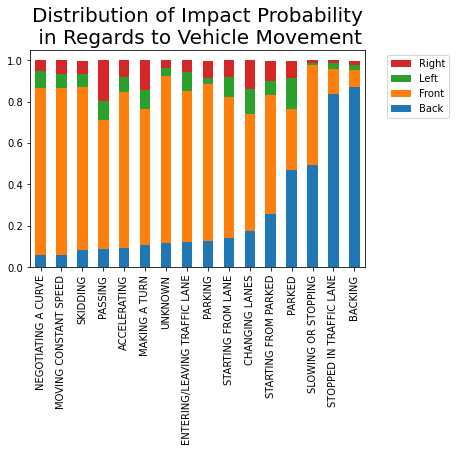

In [ ]:
movementImpact = pd.crosstab(df['Vehicle Movement'], df['First Impact Simple'])
movementImpact = movementImpact.div(df['Vehicle Movement'].value_counts(), axis=0)
movementImpact.sort_values('Back').plot.bar(stacked=True)
plt.title('Distribution of Impact Probability\n in Regards to Vehicle Movement', size=20)
plt.ylabel('')
plt.xlabel('')
current_handles, curr_labels = plt.gca().get_legend_handles_labels()
reversed_handles = reversed(current_handles)
reverse_labels = reversed(curr_labels)

plt.legend(reversed_handles, reverse_labels, bbox_to_anchor=(1.05, 1.0), loc='upper left');

Most bars appear to have large probabilities of being hit in the front of the car, which we know comes with varying degrees of injury. Though this is less true when we look at backing up or being stopped in a traffic lane. In these instances, the probability of being hit from behind is much higher, and being hit toward the front are much smaller when compared to other movements. The exception to this is when slowing down or stopping a vehicle, in which case the chance of collision between the front and back are more evenly distributed. These more defensive driving motions may explain why there is little to no chance of a fatal accident occurring when being hit from behind. This is also supported by "Negotiating A Curve" which is the movement with the lowest chance of being hit from behind, which also happens to be the movement with the highest chance of injury. It also seems like we have the most amount of first impacts on the right side of the car when passing and making a turn which might occur when recklessly going into the desired lane.

## **Conclusion**

We learned about potential  factors that may lead to higher chances in injury at the time of a collision. The first of these factors being the type of vehicle, in which we found that motorcycles have a very high chance of serious if not fatal injuries. We also learned that slower and more defensive driving leads to a lower chance of serious injury, and a higher chance of being hit in the back of the vehicle, which adds many layers of protection to the driver. This is in contrast to more aggressive and reckless driving, which has a higher chance of resulting in a collision in the front of the vehicle, which has a high chance of resulting in some form of injury. We had issues figuring out how to display data in a manner that was easily readable and interpretable, which resulted in going back and cleaning the data more thoroughly. Overall, we learned some valuable information on the causes of injury in the event of a collision, so that we may potentially look out for and avoiding them.